In [1]:
import gc
import json
import os
import sys
from dataclasses import dataclass, field
from functools import partial
from typing import Dict, List, Optional

import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from einops import einsum
from matplotlib.gridspec import GridSpec
from safetensors.torch import load_file
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from sae.data import chunk_and_tokenize

sys.path.append("..")

%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
ckpt_path = "/home/sid/tensor-sae/checkpoints/pythia14m-all-layers-rp1t/pythia70m-all-layers-rp1t-sample_20240912_003009/layers.0_layers.1_layers.2_layers.3_layers.4_layers.5/sae-915.safetensors"
model_name = "EleutherAI/pythia-70m"

In [3]:
# to use jacrevd need eager implementation
model = AutoModelForCausalLM.from_pretrained(
    model_name, attn_implementation="eager"
).cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name)

sae_ckpt = load_file(ckpt_path, device="cuda:0")

feature_encoder_weights = sae_ckpt.get("encoder.weight", sae_ckpt.get("weight"))
feature_encoder_bias = sae_ckpt.get("encoder.bias", sae_ckpt.get("bias"))
# legacy keys
feature_decoder_weights = sae_ckpt["decoder.weight"]
feature_decoder_bias = sae_ckpt["decoder.bias"]

In [4]:
seed = 42
seq_len = 64
num_samples = 100

dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
)

dataset = dataset.train_test_split(
    test_size=0.8, seed=seed
).get("test").select(range(num_samples))

tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=seq_len)

In [5]:
@dataclass
class InterventionOutputs:
    activation_positions: torch.Tensor
    clean_base_outputs: torch.Tensor
    intervened_later_outputs: torch.Tensor
    v_j: torch.Tensor
    v_k: torch.Tensor
    is_valid: torch.Tensor

In [6]:
@dataclass
class FeatureStats:
    causality: List[float] = field(default_factory=list)
    cosine: List[float] = field(default_factory=list)
    error: List[float] = field(default_factory=list)
    feature_activation_strength: List[float] = field(default_factory=list)


@dataclass
class GlobalFeatureStatistics:
    feature_activation_rate: torch.Tensor
    acc_features: torch.Tensor
    total_active_features: float
    avg_active_features_per_token: float
    feature_dict: Dict[int, FeatureStats]


def compute_feature_statistics(
    model,
    tokenized,
    feature_encoder_weights,
    feature_encoder_bias,
    sae_top_k: int = 128,
    batch_size: int = 256,
    exclude_first_k_tokens: int = 4,
):
    # (N,)
    global_feature_activation_frequencies = torch.zeros(
        feature_encoder_weights.shape[0], device=model.device
    )
    # TODO also accumulate feature activations for global strength statistic
    global_acc_feature_activations = torch.zeros(
        feature_encoder_weights.shape[0], device=model.device
    )

    dataloader = torch.utils.data.DataLoader(
        tokenized, batch_size=batch_size, shuffle=False
    )

    for batch in tqdm(dataloader, desc="Processing batches"):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = torch.ones_like(input_ids, device=model.device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
            )
            hiddens = outputs.hidden_states

        stacked_hiddens = torch.cat(hiddens[1:], dim=-1)[:, exclude_first_k_tokens:, :]

        encoded_features = torch.einsum(
            "be,nse->nsb", feature_encoder_weights, stacked_hiddens
        )
        encoded_features = encoded_features + feature_encoder_bias.unsqueeze(
            0
        ).unsqueeze(0)

        k_th_strongest = (
            torch.topk(encoded_features, k=sae_top_k, dim=-1)
            .values[:, :, -1]
            .unsqueeze(-1)
        )

        batch_binary_mask = (encoded_features >= k_th_strongest).float()

        global_feature_activation_frequencies += batch_binary_mask.sum(dim=(0, 1))
        # Normalize to prevent overflow
        global_acc_feature_activations += encoded_features.sum(dim=(0, 1)).norm(dim=-1)

    seq_len = tokenized[0]["input_ids"].shape[0] - exclude_first_k_tokens
    feature_activation_rate = global_feature_activation_frequencies / (
        len(tokenized) * seq_len
    )
    normalized_acc_features = global_acc_feature_activations / (
        len(tokenized) * seq_len
    )

    total_active = global_feature_activation_frequencies.sum().item()
    avg_active_per_token = total_active / (len(tokenized) * seq_len)

    feature_dict = {i: FeatureStats() for i in range(feature_encoder_weights.shape[-1])}

    return GlobalFeatureStatistics(
        feature_activation_rate=feature_activation_rate,
        acc_features=normalized_acc_features,
        total_active_features=total_active,
        avg_active_features_per_token=avg_active_per_token,
        feature_dict=feature_dict,
    )

In [7]:
def perform_intervention(
    model: torch.nn.Module,
    batch: torch.Tensor,
    global_feature_activation_rate: Optional[torch.Tensor],
    global_acc_feature_activations: Optional[torch.Tensor],
    intervention_index: int,
    readout_index: int,
    feature_encoder_weights: torch.Tensor,
    feature_encoder_bias: torch.Tensor,
    feature_decoder_weights: torch.Tensor,
    lambda_value: float = 1.0,
    num_tokens: int = 1,
    feature_top_k: int = 1,
    exclude_first_k_tokens: int = 0,
) -> InterventionOutputs:
    """
    Perform an intervention on a model's activations using Sparse Autoencoder (SAE) features.

    Args:
        model: The PyTorch model to intervene on.
        batch: Input tensor to the model.
        global_feature_activation_rate: the global feature activation rate statistic
        global_acc_feature_activations: the global accumulated feature activations statistic
        intervention_index: Index of the layer to intervene on.
        readout_index: Index of the layer to read out from.
        feature_encoder_weights: Weights of the SAE encoder.
        feature_encoder_bias: Bias of the SAE encoder.
        feature_decoder_weights: Weights of the SAE decoder.
        lambda_value: Strength of the intervention (default: 1.0).
        num_tokens: Number of tokens to intervene on (default: 1).
        feature_top_k: Index of the specific feature to intervene on.
        exclude_first_k_tokens: Number of tokens to exclude from the beginning (default: 0).

    Returns:
        the results of the intervention as an InterventionOutputs object
    """

    activation_positions = None
    clean_base_outputs = None
    intervened_late_outputs = None
    # j < k in layer idx
    v_j = None
    v_k = None
    is_valid = None

    num_tokens = min(
        num_tokens, max(1, batch["input_ids"].shape[1] - exclude_first_k_tokens)
    )

    # Compute top-k index based on global activation rates
    # (or accumulated activation for each feature)
    _, top_k_feature_index = torch.kthvalue(
        global_feature_activation_rate
        if global_acc_feature_activations is None
        else global_acc_feature_activations,
        k=feature_top_k,
        dim=-1,
    )

    def strengthen_specific_features(module, input, output, layer_offset=0):
        nonlocal \
            activation_positions, \
            clean_base_outputs, \
            intervened_late_outputs, \
            v_j, \
            v_k, \
            is_valid

        embed_dim = output[0].shape[-1]
        feature_encoder_segment = feature_encoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]
        feature_decoder_segment = feature_decoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]

        # Encode input activations after excluding first k tokens
        feature_activation = (
            einsum(
                output[0][:, exclude_first_k_tokens:],
                feature_encoder_segment.T,
                "b s e, e n -> b s n",
            )
            - feature_encoder_bias
        )[:, :, top_k_feature_index]

        batch_size, seq_len, _ = output[0].shape
        clean_base_outputs = output[0]

        # Get the decoder vectors for the specified feature index
        v_j = feature_decoder_segment[None, top_k_feature_index, :]

        # Select the tokens with the highest activation of the pinned feature
        _, activation_positions = torch.topk(feature_activation, k=num_tokens, dim=1)
        activation_positions += exclude_first_k_tokens  # Adjust positions

        # Create a mask for the selected token positions
        token_mask = torch.zeros(
            batch_size,
            seq_len - exclude_first_k_tokens,
            device=output[0].device,
        )
        token_mask.scatter_(1, activation_positions - exclude_first_k_tokens, 1)

        new_output = output[0].clone()
        intervened_late_outputs = new_output
        # Add intervention lambda * v_j to selected token positions after exclusion
        new_output[:, exclude_first_k_tokens:] += lambda_value * torch.einsum(
            "be,bs->bse", v_j, token_mask
        )
        new_outputs = [new_output] + list(output[1:])

        # Assign v_k
        intervention_decoder_segment = feature_decoder_weights[
            :,
            (readout_index - layer_offset) * embed_dim : (
                readout_index - layer_offset + 1
            )
            * embed_dim,
        ]
        v_k = intervention_decoder_segment[None, top_k_feature_index, :]

        # Check if the feature fires in any of the tokens after exclusion
        is_valid = token_mask.any(dim=1).bool()

        return tuple(new_outputs)

    if "gpt" in model_name:
        intervention_hook = model.transformer.h[
            intervention_index
        ].register_forward_hook(
            partial(strengthen_specific_features, layer_offset=intervention_index)
        )
    else:
        intervention_hook = model.gpt_neox.layers[
            intervention_index
        ].register_forward_hook(
            partial(strengthen_specific_features, layer_offset=intervention_index)
        )

    with intervention_hook, torch.no_grad():
        model(**batch)

    return InterventionOutputs(
        activation_positions, clean_base_outputs, intervened_late_outputs, v_j, v_k, is_valid
    )

In [8]:
# Usage
stats = compute_feature_statistics(
    model,
    tokenized,
    feature_encoder_weights,
    feature_encoder_bias,
    sae_top_k=128
)

print(f"Total number of active features: {stats.total_active_features}")
print(f"Average number of active features per token: {stats.avg_active_features_per_token:.2f}")

Processing batches:   0%|          | 0/7 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

Total number of active features: 13301770.0
Average number of active features per token: 128.00


In [9]:
# Example usage with specific feature indices
intervention_index = 4
readout_index = 5
text = ["Hello, world!", "Hello, world!"]
test_batch = tokenizer(text, return_tensors="pt").to("cuda")

feature_top_k = 10

intervention = perform_intervention(
    model=model,
    batch=test_batch,
    global_feature_activation_rate=stats.feature_activation_rate,
    global_acc_feature_activations=stats.acc_features,
    intervention_index=intervention_index,
    readout_index=readout_index,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    lambda_value=1.0,
    num_tokens=1,
    feature_top_k=feature_top_k,
    exclude_first_k_tokens=1,
)

### Causal Attribution

In [10]:
from torch.func import functional_call, jacrev, vmap


def compute_jacobian(model, j_activations, pos, j, k):
    """
    Compute batched Jacobians of layer k's activations w.r.t. layer j's activations for select tokens.

    Args:
    - model: The language model (GPT2Model or similar)
    - j_activations: Activations of layer j (shape: [batch_size, seq_len, hidden_size])
    - pos: Token positions (shape: [batch_size, num_selected_tokens])
    - j: Index of the input layer
    - k: Index of the output layer

    Returns:
    - Batch of Jacobians
    """
    j_activations.requires_grad_(True)

    def forward_to_k(x):
        activations = x.unsqueeze(1)
        for layer_idx in range(j, k + 1):
            layer, params = get_layer_and_params(model, layer_idx)
            activations = functional_call(layer, params, activations)[0]
        return activations

    def get_layer_and_params(model, layer_idx):
        if "gpt2" in model.__class__.__name__.lower():
            layer = model.transformer.h[layer_idx]
        else:
            layer = model.gpt_neox.layers[layer_idx]
        return layer, dict(layer.named_parameters())

    # Select and sum activations for specified positions
    selected_activations = j_activations.gather(
        1, pos.unsqueeze(-1).expand(-1, -1, j_activations.shape[-1])
    ).sum(dim=1, keepdim=True)

    # Compute Jacobian
    jacobian = vmap(jacrev(forward_to_k))(selected_activations)

    return jacobian.squeeze()

Sanity check to make sure Jacobian is correct

In [11]:
# Collect activations from GPT2
sample = tokenized[0:2]["input_ids"]

j, k = 1, 2
lam = 1e-2

# Perform intervention
intervention = perform_intervention(
    model=model,
    batch={
        "input_ids": sample.cuda(),
        "attention_mask": torch.ones_like(sample, device="cuda:0"),
    },
    global_feature_activation_rate=stats.feature_activation_rate,
    global_acc_feature_activations=stats.acc_features,
    intervention_index=j,
    readout_index=k,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    lambda_value=lam,
    num_tokens=1,
    feature_top_k=1,
    exclude_first_k_tokens=0,
)

# Perform clean run (no intervention)
clean_intervention = perform_intervention(
    model=model,
    batch={
        "input_ids": sample.cuda(),
        "attention_mask": torch.ones_like(sample, device="cuda:0"),
    },
    global_feature_activation_rate=stats.feature_activation_rate,
    global_acc_feature_activations=stats.acc_features,
    intervention_index=j,
    readout_index=k,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    lambda_value=0,
    num_tokens=1,
    feature_top_k=1,
    exclude_first_k_tokens=0,
)

# Compute Jacobian
jacobian = compute_jacobian(
    model, intervention.clean_base_outputs, intervention.activation_positions, j, k
)

# Check consequent_embeddings ~= original_embeddings_at_the_higher_layer + jacobian @ v_j * lam
with torch.no_grad():
    jacobian_approx = clean_intervention.intervened_later_outputs.clone()

    # Create a mask for the selected token positions
    batch_size, seq_len, _ = jacobian_approx.shape
    token_mask = torch.zeros(batch_size, seq_len, device=jacobian_approx.device)
    token_mask.scatter_(1, intervention.activation_positions, 1)

    # Apply lam * JVP only at the correct activation positions
    jvp = lam * torch.einsum("j,bij->bi", intervention.v_j.squeeze(), jacobian)
    jacobian_approx += jvp.unsqueeze(1) * token_mask.unsqueeze(-1)

error = torch.mean((intervention.intervened_later_outputs - jacobian_approx) ** 2)

print(f"error: {error}")

error: 1.3178367286315051e-09


/home/sid/miniconda3/envs/sae/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [12]:
@torch.no_grad()
def compute_causal_attribution_strength(
    j: int,
    k: int,
    model: torch.nn.Module,
    inputs: Dict[str, torch.Tensor],
    feature_encoder_weights: torch.Tensor,
    feature_encoder_bias: torch.Tensor,
    feature_decoder_weights: torch.Tensor,
    global_feature_activation_rate: torch.Tensor,
    global_acc_feature_activations: torch.Tensor,
    lambda_value: float = 1.0,
    feature_top_k: int = 1,
    num_tokens: int = 1,
    exclude_first_k_tokens: int = 0,
):
    def perform_intervention_and_compute_jacobian():
        intervention = perform_intervention(
            model=model,
            batch=inputs,
            global_feature_activation_rate=global_feature_activation_rate,
            global_acc_feature_activations=global_acc_feature_activations,
            intervention_index=j,
            readout_index=k,
            feature_encoder_weights=feature_encoder_weights,
            feature_encoder_bias=feature_encoder_bias,
            feature_decoder_weights=feature_decoder_weights,
            lambda_value=lambda_value,
            num_tokens=num_tokens,
            feature_top_k=feature_top_k,
            exclude_first_k_tokens=exclude_first_k_tokens,
        )

        jacobian = compute_jacobian(
            model,
            intervention.clean_base_outputs,
            intervention.activation_positions,
            j,
            k,
        )

        return intervention, jacobian

    def compute_metrics(intervention, jacobian):
        v_k_norm_squared = torch.norm(intervention.v_k, p=2, dim=-1).pow(2)

        proportion_explained = (
            torch.einsum(
                "bie,be,bi->b",
                jacobian,
                intervention.v_j.squeeze(1),
                intervention.v_k.squeeze(1),
            )
            / v_k_norm_squared
        )

        pred = torch.einsum("bie,be->bi", jacobian, intervention.v_j.squeeze(1))
        causal_cosine = F.cosine_similarity(pred, intervention.v_k.squeeze(1), dim=-1)

        error = torch.mean((pred - intervention.v_k.squeeze(1)) ** 2, dim=-1)
        relative_error = error / v_k_norm_squared

        return proportion_explained, causal_cosine, error, relative_error

    intervention, jacobian = perform_intervention_and_compute_jacobian()
    metrics = compute_metrics(intervention, jacobian)

    return (
        *metrics,
        jacobian,
        intervention.v_j,
        intervention.v_k,
        intervention.is_valid,
    )


def plot_histograms(data, params):
    num_plots = len(data)
    num_cols = 2
    num_rows = (num_plots + 1) // 2
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10 * num_rows))
    fig.suptitle("Distribution of Metrics", fontsize=16)

    metrics = list(data.keys())
    titles = [
        "Causality Distribution",
        "Causal Cosine Distribution",
        "Error Distribution",
        "Relative Error Distribution",
    ]
    xlabels = ["Causality", "Causal Cosine", "Error", "Relative Error"]

    for idx, (metric, title, xlabel) in enumerate(zip(metrics, titles, xlabels)):
        ax = axs[idx // num_cols, idx % num_cols] if num_rows > 1 else axs[idx]
        for param, values in data[metric].items():
            ax.hist(values, bins=50, alpha=0.5, label=f"{param}")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Frequency")
        ax.legend(loc="upper right", fontsize="small")  # Place legend inside the plot
        ax.grid(True)
        if metric == "causality":
            ax.set_xlim(0, 2)

    plt.tight_layout()
    plt.show()


def process_batch(
    batch,
    model,
    i,
    j,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    lambda_value,
    feature_top_k,
    num_tokens,
    exclude_first_k_tokens,
):
    inputs = {"input_ids": batch["input_ids"].cuda()}
    return compute_causal_attribution_strength(
        j=i,
        k=j,
        model=model,
        inputs=inputs,
        feature_encoder_weights=feature_encoder_weights,
        feature_encoder_bias=feature_encoder_bias,
        feature_decoder_weights=feature_decoder_weights,
        global_feature_activation_rate=stats.feature_activation_rate,
        global_acc_feature_activations=stats.acc_features,
        lambda_value=lambda_value,
        feature_top_k=feature_top_k,
        num_tokens=num_tokens,
        exclude_first_k_tokens=exclude_first_k_tokens,
    )


def process_dataset(model, dataset, batch_size, **kwargs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    metrics = {
        "causality": [],
        "causal_cosines": [],
        "errors": [],
        "relative_errors": [],
    }

    for batch in tqdm(dataloader, desc="Processing batches"):
        results = process_batch(batch, model, **kwargs)
        causality, causal_cosine, error, relative_error, _, _, _, is_valid = results

        for metric, value in zip(
            metrics.keys(), [causality, causal_cosine, error, relative_error]
        ):
            metrics[metric].extend(value[is_valid].cpu().numpy())

    return {k: np.array(v) for k, v in metrics.items()}


def run_evaluation(
    params,
    model,
    dataset,
    batch_size,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    exclude_first_k_tokens,
):
    results = {
        metric: {}
        for metric in ["causality", "causal_cosines", "errors", "relative_errors"]
    }

    for i in params["i"]:
        for j in params["j"]:
            if i >= j:
                continue  # Skip invalid layer combinations
            for lambda_value in params["lambda_value"]:
                for feature_top_k in params["feature_select_k"]:
                    for num_tokens in params["num_tokens"]:
                        key = f"i={i}, j={j}, λ={lambda_value}, k={feature_top_k}, tokens={num_tokens}"
                        batch_results = process_dataset(
                            model=model,
                            dataset=dataset,
                            batch_size=batch_size,
                            i=i,
                            j=j,
                            feature_encoder_weights=feature_encoder_weights,
                            feature_encoder_bias=feature_encoder_bias,
                            feature_decoder_weights=feature_decoder_weights,
                            lambda_value=lambda_value,
                            feature_top_k=feature_top_k,
                            num_tokens=num_tokens,
                            exclude_first_k_tokens=exclude_first_k_tokens,
                        )
                        for metric in results:
                            results[metric][key] = batch_results[metric]

    plot_histograms(results, params)
    return results

In [13]:
# Usage example:
j, k = 1, 2
lambda_value = 1.0
feature_top_k = 1
num_tokens = 1
exclude_first_k_tokens = 0

sample = tokenized[0:2]["input_ids"]
inputs = {
    "input_ids": sample.cuda(),
    "attention_mask": torch.ones_like(sample, device="cuda:0"),
}

results = compute_causal_attribution_strength(
    j,
    k,
    model,
    inputs,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    stats.feature_activation_rate,
    stats.acc_features,
    lambda_value,
    feature_top_k,
    num_tokens,
    exclude_first_k_tokens,
)

(
    proportion_explained,
    causal_cosine,
    error,
    relative_error,
    jacobian,
    v_j,
    v_k,
    is_valid,
) = results

print(f"Proportion explained: {proportion_explained}")
print(f"Causal cosine: {causal_cosine}")
print(f"Error: {error}")
print(f"Relative error: {relative_error}")
print(f"Is valid: {is_valid}")

Proportion explained: tensor([0.2323, 0.2095], device='cuda:0')
Causal cosine: tensor([0.3673, 0.2882], device='cuda:0')
Error: tensor([0.0003, 0.0003], device='cuda:0')
Relative error: tensor([0.0018, 0.0022], device='cuda:0')
Is valid: tensor([True, True], device='cuda:0')


Processing batches: 100%|██████████| 8/8 [00:01<00:00,  6.72it/s]


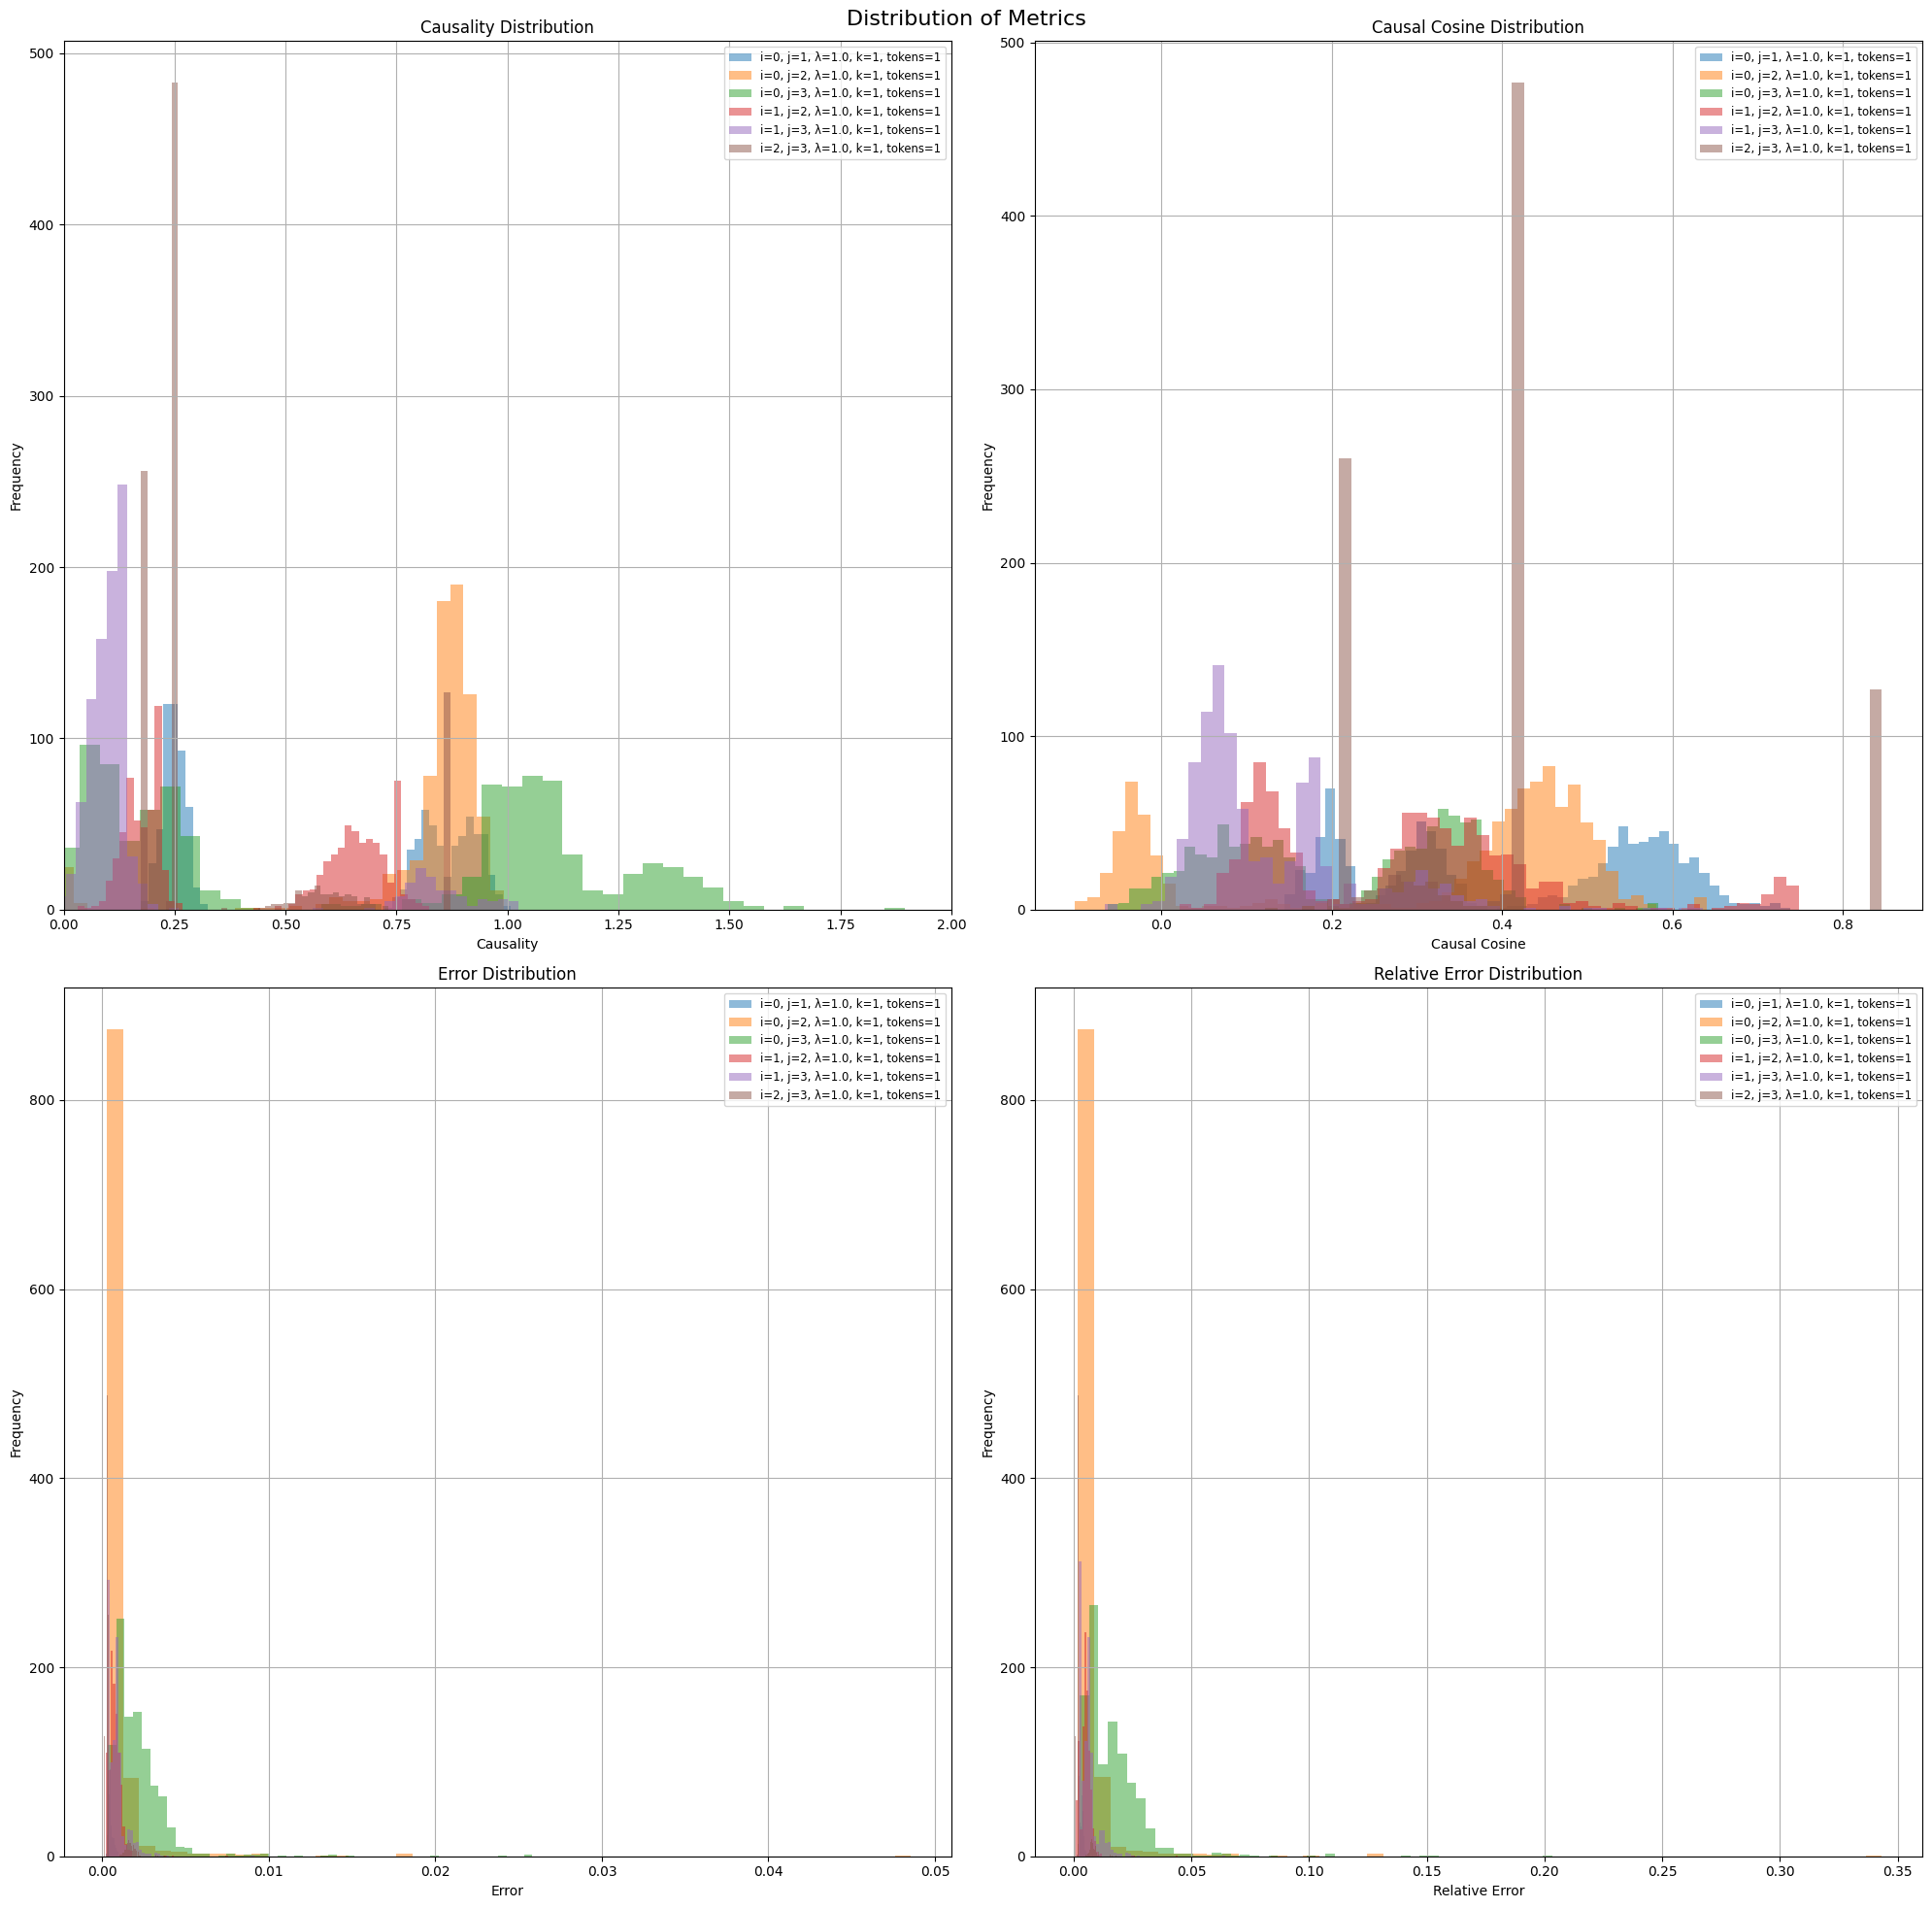

Evaluation completed and results saved.

Analysis for causality:
  i=0, j=1, λ=1.0, k=1, tokens=1:
    Mean: 0.5657
    Std: 0.3140
    Min: 0.1746
    Max: 1.0063
  i=0, j=2, λ=1.0, k=1, tokens=1:
    Mean: 0.6270
    Std: 0.4024
    Min: -0.5219
    Max: 0.9917
  i=0, j=3, λ=1.0, k=1, tokens=1:
    Mean: 0.6309
    Std: 0.5110
    Min: -0.3725
    Max: 1.8947
  i=1, j=2, λ=1.0, k=1, tokens=1:
    Mean: 0.4270
    Std: 0.2527
    Min: 0.0309
    Max: 0.8235
  i=1, j=3, λ=1.0, k=1, tokens=1:
    Mean: 0.1934
    Std: 0.2531
    Min: -0.1347
    Max: 1.0248
  i=2, j=3, λ=1.0, k=1, tokens=1:
    Mean: 0.3545
    Std: 0.2326
    Min: 0.1739
    Max: 0.8710

Analysis for causal_cosines:
  i=0, j=1, λ=1.0, k=1, tokens=1:
    Mean: 0.4143
    Std: 0.1677
    Min: 0.1447
    Max: 0.7384
  i=0, j=2, λ=1.0, k=1, tokens=1:
    Mean: 0.3128
    Std: 0.2155
    Min: -0.1015
    Max: 0.6405
  i=0, j=3, λ=1.0, k=1, tokens=1:
    Mean: 0.2057
    Std: 0.1369
    Min: -0.0635
    Max: 0.5834
  i=1, j=

In [14]:
# Example usage:
params = {
    "i": [0, 1, 2],  # Layer indices for intervention
    "j": [1, 2, 3],  # Layer indices for readout
    "lambda_value": [1.0],
    "feature_select_k": [1],
    "num_tokens": [1],
    "feature_select_percentile": [None],
}

# Clear GPU memory and garbage collect
torch.cuda.empty_cache()
gc.collect()

# Assuming 'tokenized' is your dataset and other variables are defined
sample_size = 1000
batch_size = 128
exclude_first_k_tokens = 0

# Select a subset of the dataset
sample_dataset = tokenized.select(range(sample_size))

# Run the evaluation
results = run_evaluation(
    params=params,
    model=model,
    dataset=sample_dataset,
    batch_size=batch_size,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    exclude_first_k_tokens=exclude_first_k_tokens,
)

# Optional: Save results
# import pickle

# with open('evaluation_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

print("Evaluation completed and results saved.")

# Optional: Analyze results
for metric, data in results.items():
    print(f"\nAnalysis for {metric}:")
    for key, values in data.items():
        print(f"  {key}:")
        print(f"    Mean: {np.mean(values):.4f}")
        print(f"    Std: {np.std(values):.4f}")
        print(f"    Min: {np.min(values):.4f}")
        print(f"    Max: {np.max(values):.4f}")

In [ ]:
def calculate_layer_norms(weights, num_layers):
    """Calculate norms for each layer of the given weights."""
    layer_size = weights.shape[1] // num_layers
    layer_weights = torch.split(weights, layer_size, dim=1)
    return torch.stack([layer.norm(dim=1) for layer in layer_weights])

def bin_features_by_layer(feature_encoder_weights, feature_decoder_weights, num_layers):
    """Bin features by their max norm layer for both encoder and decoder."""
    enc_norms = calculate_layer_norms(feature_encoder_weights, num_layers)
    dec_norms = calculate_layer_norms(feature_decoder_weights, num_layers)
    
    enc_max_norm_layers = enc_norms.argmax(dim=0)
    dec_max_norm_layers = dec_norms.argmax(dim=0)
    
    enc_layer_features = [[] for _ in range(num_layers)]
    dec_layer_features = [[] for _ in range(num_layers)]
    
    for feature_idx, (enc_layer_idx, dec_layer_idx) in enumerate(zip(enc_max_norm_layers, dec_max_norm_layers)):
        enc_layer_features[enc_layer_idx.item()].append(feature_idx)
        dec_layer_features[dec_layer_idx.item()].append(feature_idx)
    
    enc_layer_features = [torch.tensor(features, device=feature_encoder_weights.device) for features in enc_layer_features]
    dec_layer_features = [torch.tensor(features, device=feature_decoder_weights.device) for features in dec_layer_features]
    
    return enc_layer_features, dec_layer_features

def print_feature_distribution(enc_binned_features, dec_binned_features):
    """Print summary of feature distribution across layers."""
    print("Encoder:")
    for layer, features in enumerate(enc_binned_features):
        print(f"Layer {layer}: {len(features)} features")

    print("\nDecoder:")
    for layer, features in enumerate(dec_binned_features):
        print(f"Layer {layer}: {len(features)} features")

def plot_feature_distribution(enc_binned_features, dec_binned_features, num_layers):
    """Visualize the distribution of features across layers."""
    enc_feature_counts = [len(features) for features in enc_binned_features]
    dec_feature_counts = [len(features) for features in dec_binned_features]

    plt.figure(figsize=(12, 6))
    x = range(num_layers)
    width = 0.35

    plt.bar([i - width/2 for i in x], enc_feature_counts, width, label='Encoder', alpha=0.8)
    plt.bar([i + width/2 for i in x], dec_feature_counts, width, label='Decoder', alpha=0.8)

    plt.title("Distribution of Features Across Layers by Max Norm")
    plt.xlabel("Layer")
    plt.ylabel("Number of Features")
    plt.legend()

    plt.xticks(x)
    plt.tight_layout()
    plt.show()

# Usage example:
num_layers = 6  # Adjust this based on your model's architecture
enc_binned_features, dec_binned_features = bin_features_by_layer(feature_encoder_weights, feature_decoder_weights, num_layers)

print_feature_distribution(enc_binned_features, dec_binned_features)
plot_feature_distribution(enc_binned_features, dec_binned_features, num_layers)

Processing layers: 100%|██████████| 6/6 [02:07<00:00, 21.26s/it]


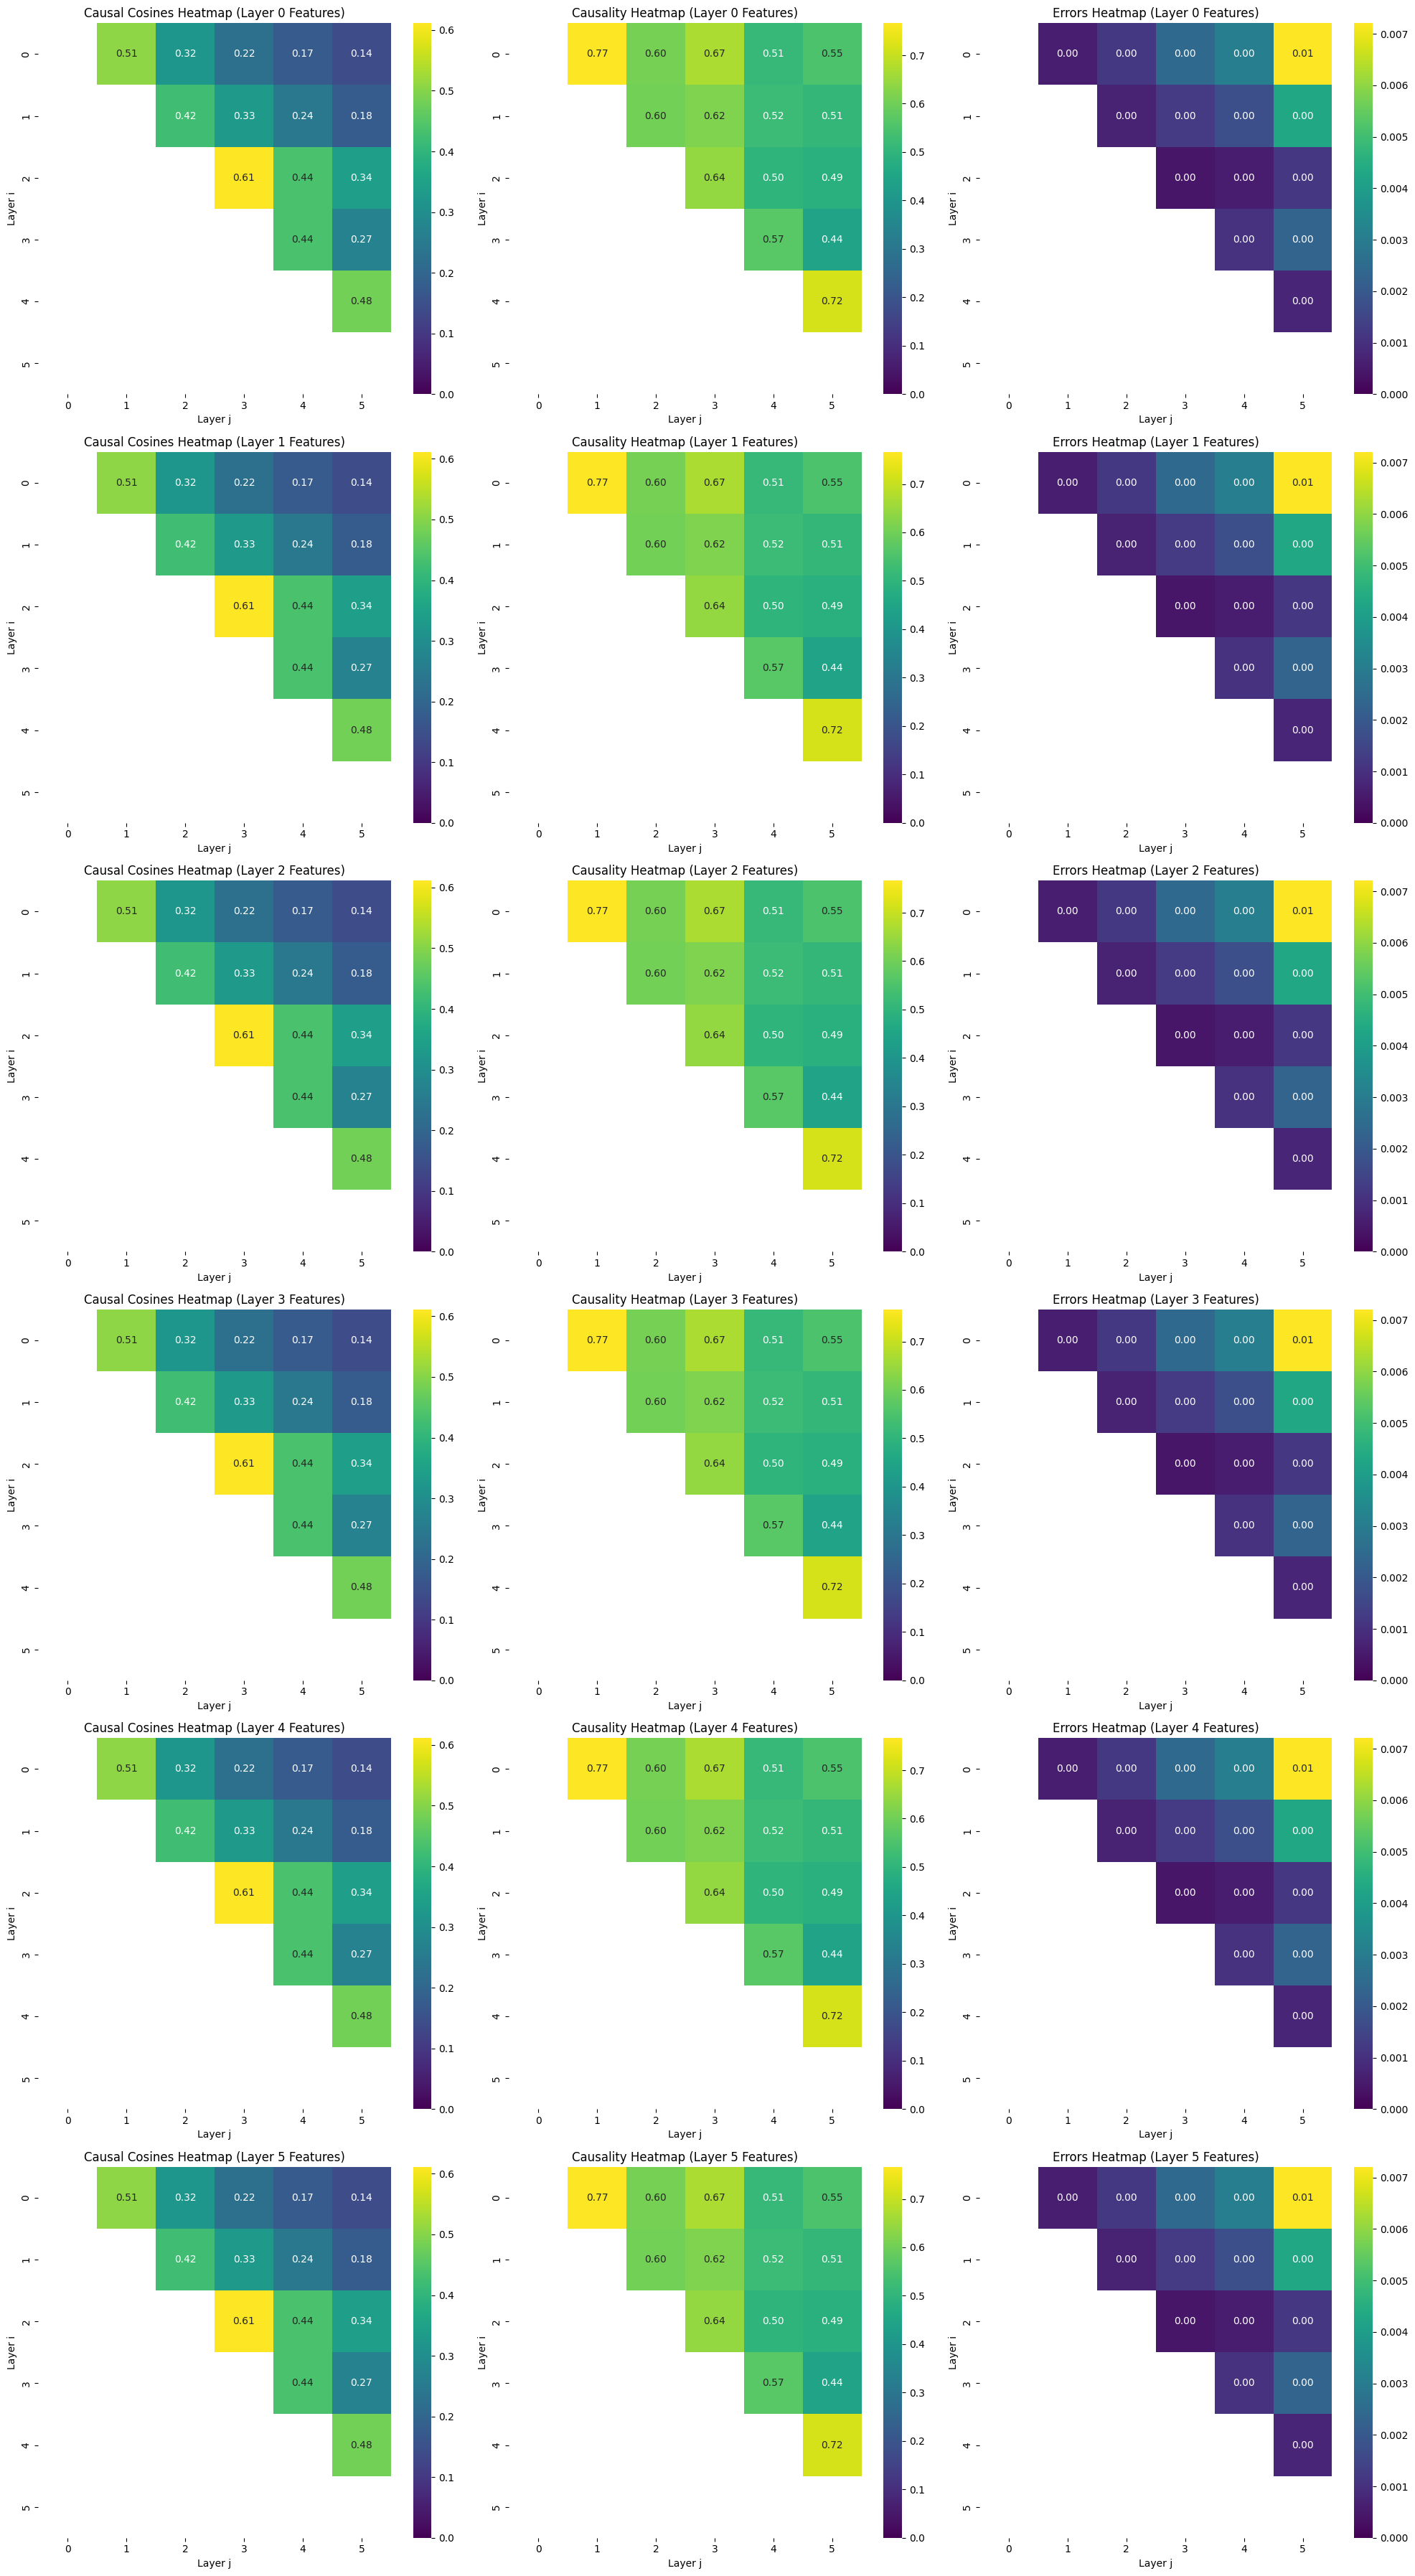

In [24]:
def select_top_k_features(
    global_statistic, layer_features, top_k, use_accumulated=False
):
    """
    Select top k features based on either activation rate or accumulated activations.

    Args:
    global_statistic: Either global_feature_activation_rate or global_acc_feature_activations
    layer_features: Features for the current layer
    top_k: Number of top features to select
    use_accumulated: If True, use accumulated activations; otherwise, use activation rate

    Returns:
    Top k feature indices for the layer
    """
    # Get statistic for the features in this layer
    layer_statistic = global_statistic[layer_features]

    # Sort features by the statistic (descending) and select top k
    _, top_k_indices = torch.topk(layer_statistic, k=min(top_k, len(layer_features)))

    return layer_features[top_k_indices]


def run_layer_pair_evaluation_top_k(
    model,
    dataset,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    global_statistic,
    num_layers,
    binned_features,
    top_k=10,
    batch_size=128,
    lambda_value=1.0,
    num_tokens=1,
    exclude_first_k_tokens=0,
    use_accumulated=False,
):
    results = {layer: {} for layer in range(num_layers)}

    for layer in tqdm(range(num_layers), desc="Processing layers"):
        layer_features = binned_features[layer]
        if len(layer_features) == 0:
            continue

        # Select top-k features based on the global statistic
        top_k_features = select_top_k_features(
            global_statistic, layer_features, top_k, use_accumulated
        )

        for i in range(num_layers):
            for j in range(i + 1, num_layers):
                layer_results = {
                    "causality": [],
                    "causal_cosines": [],
                    "errors": [],
                }

                for feature_index in top_k_features:
                    causality, causal_cosines, errors, _, _, _, _, is_valid = (
                        compute_causal_attribution_strength(
                            j=i,
                            k=j,
                            model=model,
                            inputs={"input_ids": dataset["input_ids"].cuda()},
                            feature_encoder_weights=feature_encoder_weights,
                            feature_encoder_bias=feature_encoder_bias,
                            feature_decoder_weights=feature_decoder_weights,
                            global_feature_activation_rate=global_statistic,
                            global_acc_feature_activations=None,  # Set this if needed
                            lambda_value=lambda_value,
                            feature_top_k=feature_index,
                            num_tokens=num_tokens,
                            exclude_first_k_tokens=exclude_first_k_tokens,
                        )
                    )

                    # Filter out invalid items and store results
                    if is_valid.any():
                        layer_results["causality"].append(
                            causality[is_valid].mean().item()
                        )
                        layer_results["causal_cosines"].append(
                            causal_cosines[is_valid].mean().item()
                        )
                        layer_results["errors"].append(errors[is_valid].mean().item())

                # Compute average for each metric
                results[layer][(i, j)] = {
                    metric: np.mean(values) if values else np.nan
                    for metric, values in layer_results.items()
                }

    return results


def plot_layer_heatmaps_top_k(results, num_layers):
    fig, axes = plt.subplots(num_layers, 3, figsize=(20, 6 * num_layers))

    for layer in range(num_layers):
        if not results[layer]:
            continue

        matrices = {
            "causal_cosines": np.full((num_layers, num_layers), np.nan),
            "causality": np.full((num_layers, num_layers), np.nan),
            "errors": np.full((num_layers, num_layers), np.nan),
        }

        for (i, j), values in results[layer].items():
            for metric in matrices.keys():
                matrices[metric][i, j] = values[metric]

        titles = ["Causal Cosines", "Causality", "Errors"]

        for col, (title, matrix) in enumerate(zip(titles, matrices.values())):
            ax = axes[layer, col] if num_layers > 1 else axes[col]

            # Create a mask for the lower triangle and diagonal
            mask = np.tril(np.ones_like(matrix, dtype=bool))

            sns.heatmap(
                matrix,
                ax=ax,
                cmap="viridis",
                cbar=True,
                annot=True,
                fmt=".2f",
                mask=mask,
                vmin=0,
                vmax=np.nanmax(matrix),
            )

            ax.set_title(f"{title} Heatmap (Layer {layer} Features)")
            ax.set_xlabel("Layer j")
            ax.set_ylabel("Layer i")

    plt.tight_layout()
    plt.show()


# Usage example:
num_layers = 6  # Adjust this based on your model's architecture
dataset_sample = tokenized.select(range(1000))  # Adjust sample size as needed

results = run_layer_pair_evaluation_top_k(
    model=model,
    dataset=dataset_sample,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    global_statistic=stats.feature_activation_rate,  # Or use stats.acc_features
    num_layers=num_layers,
    binned_features=enc_binned_features,
    top_k=1,
    batch_size=128,
    lambda_value=1.0,
    num_tokens=1,
    exclude_first_k_tokens=0,
    use_accumulated=False,  # Set to True if using accumulated activations
)

# Plot the heatmaps
plot_layer_heatmaps_top_k(results, num_layers)

Processing layers: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Debug: Entering plot_combined_heatmaps
Debug: Plotting causal_cosines
Debug: causal_cosines matrix:
[[       nan 0.56291878        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]]
Debug: Plotting causality
Debug: causality matrix:
[[       nan 0.80970621        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]]
Debug: Plotting errors
Debug: errors matrix:
[[       nan 0.00054426        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]]


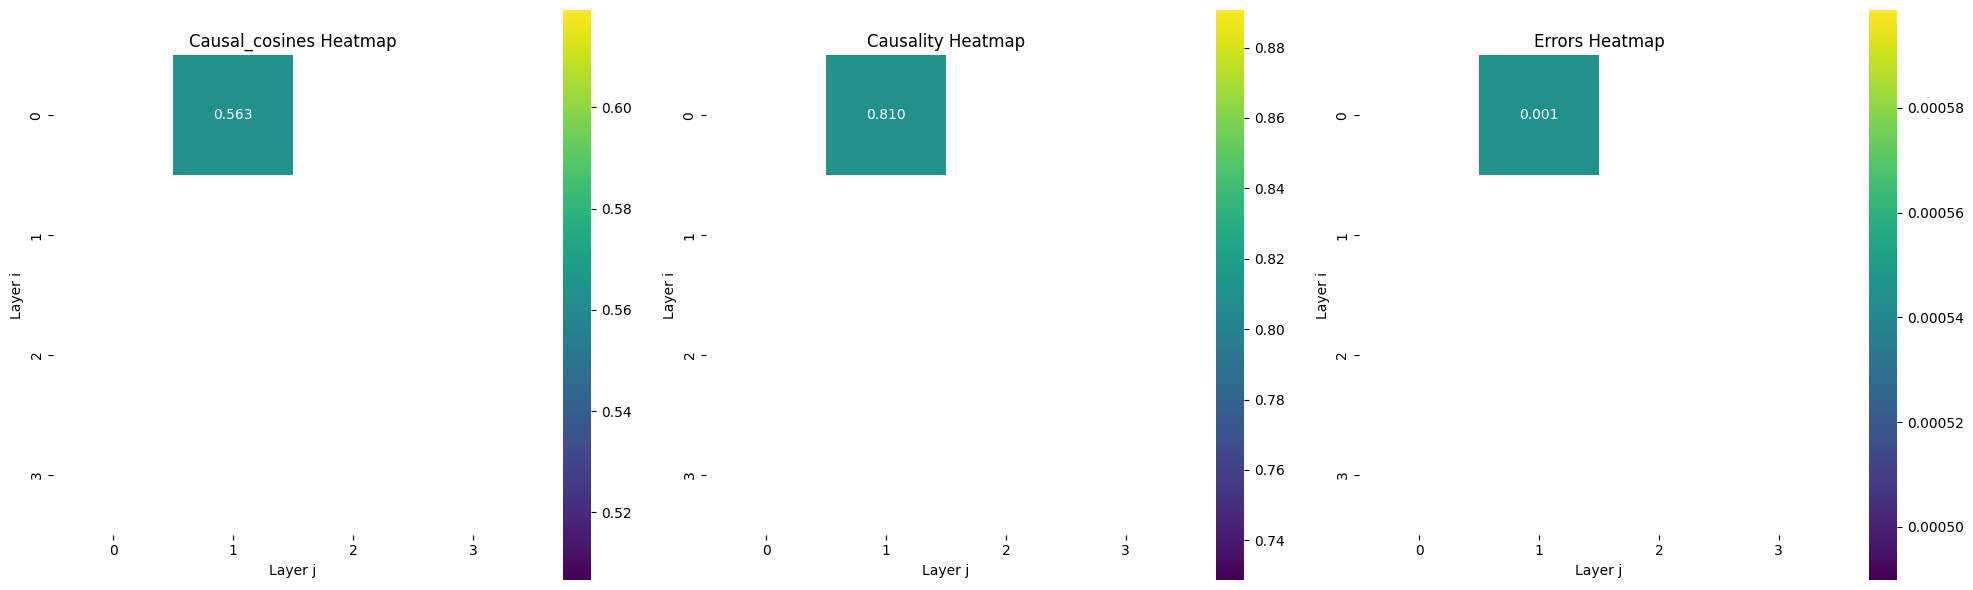

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def plot_combined_heatmaps(results, num_layers):
    print("Debug: Entering plot_combined_heatmaps")
    
    metrics = ["causal_cosines", "causality", "errors"]
    combined_matrices = {metric: np.full((num_layers, num_layers), np.nan) for metric in metrics}
    
    for layer, layer_data in results.items():
        for (i, j), values in layer_data.items():
            for metric in metrics:
                if metric in values and values[metric]:
                    combined_matrices[metric][i, j] = np.mean(values[metric])
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for idx, (title, matrix) in enumerate(combined_matrices.items()):
        print(f"Debug: Plotting {title}")
        print(f"Debug: {title} matrix:")
        print(matrix)
        
        ax = axes[idx]
        mask = np.tril(np.ones_like(matrix, dtype=bool))
        
        sns.heatmap(
            matrix,
            ax=ax,
            cmap="viridis",
            cbar=True,
            annot=True,
            fmt=".3f",
            mask=mask,
            square=True,
            vmin=np.nanmin(matrix),
            vmax=np.nanmax(matrix)
        )
        
        ax.set_title(f"{title.capitalize()} Heatmap")
        ax.set_xlabel("Layer j")
        ax.set_ylabel("Layer i")
    
    plt.tight_layout()
    plt.show()

# Run the evaluation (assuming this part is working correctly)
results_activation_rate = run_layer_pair_evaluation_top_k(
    model=model,
    dataset=dataset_sample,
    feature_encoder_weights=feature_encoder_weights,
    feature_encoder_bias=feature_encoder_bias,
    feature_decoder_weights=feature_decoder_weights,
    global_feature_activation_rate=stats.feature_activation_rate,
    global_acc_feature_activations=stats.acc_features,
    num_layers=num_layers,
    binned_features=enc_binned_features,
    top_k=1,
    use_accumulated=False,
)

# Plot the combined heatmaps
plot_combined_heatmaps(results_activation_rate, 4)

### Empirical Analysis of Encoder/Decoder Norms

In [ ]:
def plot_feature_activation_distribution(global_feature_activation_rate):
    plt.figure(figsize=(12, 6))
    plt.hist(global_feature_activation_rate.cpu().numpy(), bins=50)
    plt.title("Distribution of Feature Activation Rates")
    plt.xlabel("Activation Rate")
    plt.ylabel("Number of Features")
    plt.ylim(0, 100)  # Restrict y-axis to a maximum height of 100
    plt.show()

# Usage:
# plot_feature_activation_distribution(stats.feature_activation_rate)

In [ ]:
def filter_inactive_features(
    feature_activation_rate,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
    min_activation_rate=0.01,
):
    """
    Filter out features with activation rates below the specified threshold.

    Args:
    feature_activation_rate (torch.Tensor): Tensor of feature activation rates.
    feature_encoder_weights (torch.Tensor): Encoder weights.
    feature_encoder_bias (torch.Tensor): Encoder bias.
    feature_decoder_weights (torch.Tensor): Decoder weights.
    min_activation_rate (float): Minimum activation rate threshold. Default is 0.01.

    Returns:
    tuple: Filtered versions of encoder weights, encoder bias, and decoder weights.
    """
    # Identify features with activation rate above the threshold
    active_features = torch.where(feature_activation_rate > min_activation_rate)[0]

    # Create filtered versions of encoder and decoder components
    filtered_feature_encoder_weights = feature_encoder_weights[active_features]
    filtered_feature_encoder_bias = feature_encoder_bias[active_features]
    filtered_feature_decoder_weights = feature_decoder_weights[active_features]

    return (
        filtered_feature_encoder_weights,
        filtered_feature_encoder_bias,
        filtered_feature_decoder_weights,
    )


def calculate_layer_norms(weights, num_layers):
    """Calculate norms for each layer of the given weights."""
    layer_size = weights.shape[1] // num_layers
    layer_weights = torch.split(weights, layer_size, dim=1)
    return torch.stack([layer.norm(dim=1) for layer in layer_weights])


def filter_features_by_layer(encoder_norms, decoder_norms, layer_index):
    """Filter features where the specified layer has the largest norm."""
    max_norm_layers = encoder_norms.argmax(dim=0)
    layer_mask = max_norm_layers == layer_index
    return encoder_norms[:, layer_mask], decoder_norms[:, layer_mask], layer_mask


def create_norm_heatmap(norms, title, ax):
    """Create a heatmap of norms with layers on the vertical axis."""
    sns.heatmap(norms.cpu().numpy(), cmap="viridis", cbar=True, ax=ax)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Feature Index", fontsize=8)
    ax.set_ylabel("Layer", fontsize=8)
    ax.tick_params(labelsize=6)


def plot_layerwise_filtering(
    encoder_weights, decoder_weights, num_layers, save_folder=None, norm_threshold=0.01
):
    encoder_norms = calculate_layer_norms(encoder_weights, num_layers)
    decoder_norms = calculate_layer_norms(decoder_weights, num_layers)

    print(
        f"Initial shapes - Encoder: {encoder_norms.shape}, Decoder: {decoder_norms.shape}"
    )

    fig = plt.figure(figsize=(24, 7 * (num_layers + 1)))
    gs = GridSpec(num_layers + 1, 3, figure=fig, width_ratios=[1, 1, 0.5])

    # Initial plot
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    create_norm_heatmap(encoder_norms, "Initial Encoder Norms", ax1)
    create_norm_heatmap(decoder_norms, "Initial Decoder Norms", ax2)

    for i in range(num_layers):
        (filtered_encoder_norms, filtered_decoder_norms, _) = filter_features_by_layer(
            encoder_norms,
            decoder_norms,
            i,
        )

        ax1 = fig.add_subplot(gs[i + 1, 0])
        ax2 = fig.add_subplot(gs[i + 1, 1])
        ax_stats = fig.add_subplot(gs[i + 1, 2])

        if filtered_encoder_norms.numel() > 0 and filtered_decoder_norms.numel() > 0:
            create_norm_heatmap(
                filtered_encoder_norms, f"Encoder Norms (Layer {i} filtered)", ax1
            )
            create_norm_heatmap(
                filtered_decoder_norms, f"Decoder Norms (Layer {i} filtered)", ax2
            )

            # Calculate and display statistics
            active_features = (filtered_encoder_norms > norm_threshold).sum(1)
            total_features = encoder_norms.shape[1]
            percentage_active = (active_features.float() / total_features) * 100
            mean_encoder_norm = filtered_encoder_norms.mean().item()
            mean_decoder_norm = filtered_decoder_norms.mean().item()

            stats_text = (
                f"Layer {i} Statistics:\n\n"
                f"Average Active Features\nPer Layer: {active_features.float().mean().item():.2f}\n\n"
                f"Percentage Active: {percentage_active.mean().item():.2f}%\n\n"
                f"Mean Encoder Norm: {mean_encoder_norm:.4f}\n\n"
                f"Mean Decoder Norm: {mean_decoder_norm:.4f}"
            )

            ax_stats.text(
                0.5,
                0.5,
                stats_text,
                ha="center",
                va="center",
                fontsize=10,
                transform=ax_stats.transAxes,
            )
            ax_stats.axis("off")
        else:
            ax1.text(
                0.5,
                0.5,
                f"No features left after filtering layer {i}",
                ha="center",
                va="center",
            )
            ax2.text(
                0.5,
                0.5,
                f"No features left after filtering layer {i}",
                ha="center",
                va="center",
            )

        ax1.set_title(f"Encoder Norms (Layer {i} filtered)")
        ax2.set_title(f"Decoder Norms (Layer {i} filtered)")

        print(
            f"After filtering layer {i} - Active features: {filtered_encoder_norms.shape[1]}"
        )

    plt.tight_layout()
    if save_folder:
        plt.savefig(
            os.path.join(save_folder, "iterative_filtering_norms_with_stats.png"),
            dpi=300,
            bbox_inches="tight",
        )
    plt.show()


def process_layer(
    encoder_weights,
    decoder_weights,
    encoder_bias,
    layer_index,
    num_layers,
):
    """Process a single layer and return filtered weights and statistics."""
    encoder_norms = calculate_layer_norms(encoder_weights, num_layers)
    decoder_norms = calculate_layer_norms(decoder_weights, num_layers)

    filtered_encoder_norms, filtered_decoder_norms, layer_mask = (
        filter_features_by_layer(encoder_norms, decoder_norms, layer_index)
    )

    if filtered_encoder_norms.numel() == 0 or filtered_decoder_norms.numel() == 0:
        print(f"No features left after filtering layer {layer_index}")
        return {}

    num_features = filtered_encoder_norms.shape[1]

    return {
        "filtered_encoder": encoder_weights[layer_mask, :],
        "filtered_encoder_bias": encoder_bias[layer_mask],
        "filtered_decoder": decoder_weights[layer_mask, :],
        "num_features": num_features,
        "active_features": encoder_norms.shape[1],
        "mean_encoder_norm": encoder_norms.mean().item(),
        "mean_decoder_norm": decoder_norms.mean().item(),
    }


def process_all_layers(
    encoder_weights,
    decoder_weights,
    encoder_bias,
    num_layers,
    exclude_first_k_tokens,
    save_folder=None,
):
    """Process all layers and return filtering splits and metadata."""
    max_layer_filtering_splits = []
    metadata = {}

    if save_folder:
        os.makedirs(save_folder, exist_ok=True)

    for i in range(num_layers):
        result = process_layer(
            encoder_weights, decoder_weights, encoder_bias, i, num_layers
        )
        if result:
            max_layer_filtering_splits.append(result)
            metadata[f"layer_{i}"] = {
                "num_features": result["num_features"],
                "active_features": result["active_features"],
                "mean_encoder_norm": result["mean_encoder_norm"],
                "mean_decoder_norm": result["mean_decoder_norm"],
                "exclude_first_k_tokens": exclude_first_k_tokens,
            }

    if save_folder:
        with open(os.path.join(save_folder, "metadata.json"), "w") as f:
            json.dump(metadata, f, indent=2)

    return max_layer_filtering_splits, metadata


Initial shapes - Encoder: torch.Size([6, 223]), Decoder: torch.Size([6, 223])
After filtering layer 0 - Active features: 195
After filtering layer 1 - Active features: 11
After filtering layer 2 - Active features: 2
After filtering layer 3 - Active features: 2
After filtering layer 4 - Active features: 3
After filtering layer 5 - Active features: 10


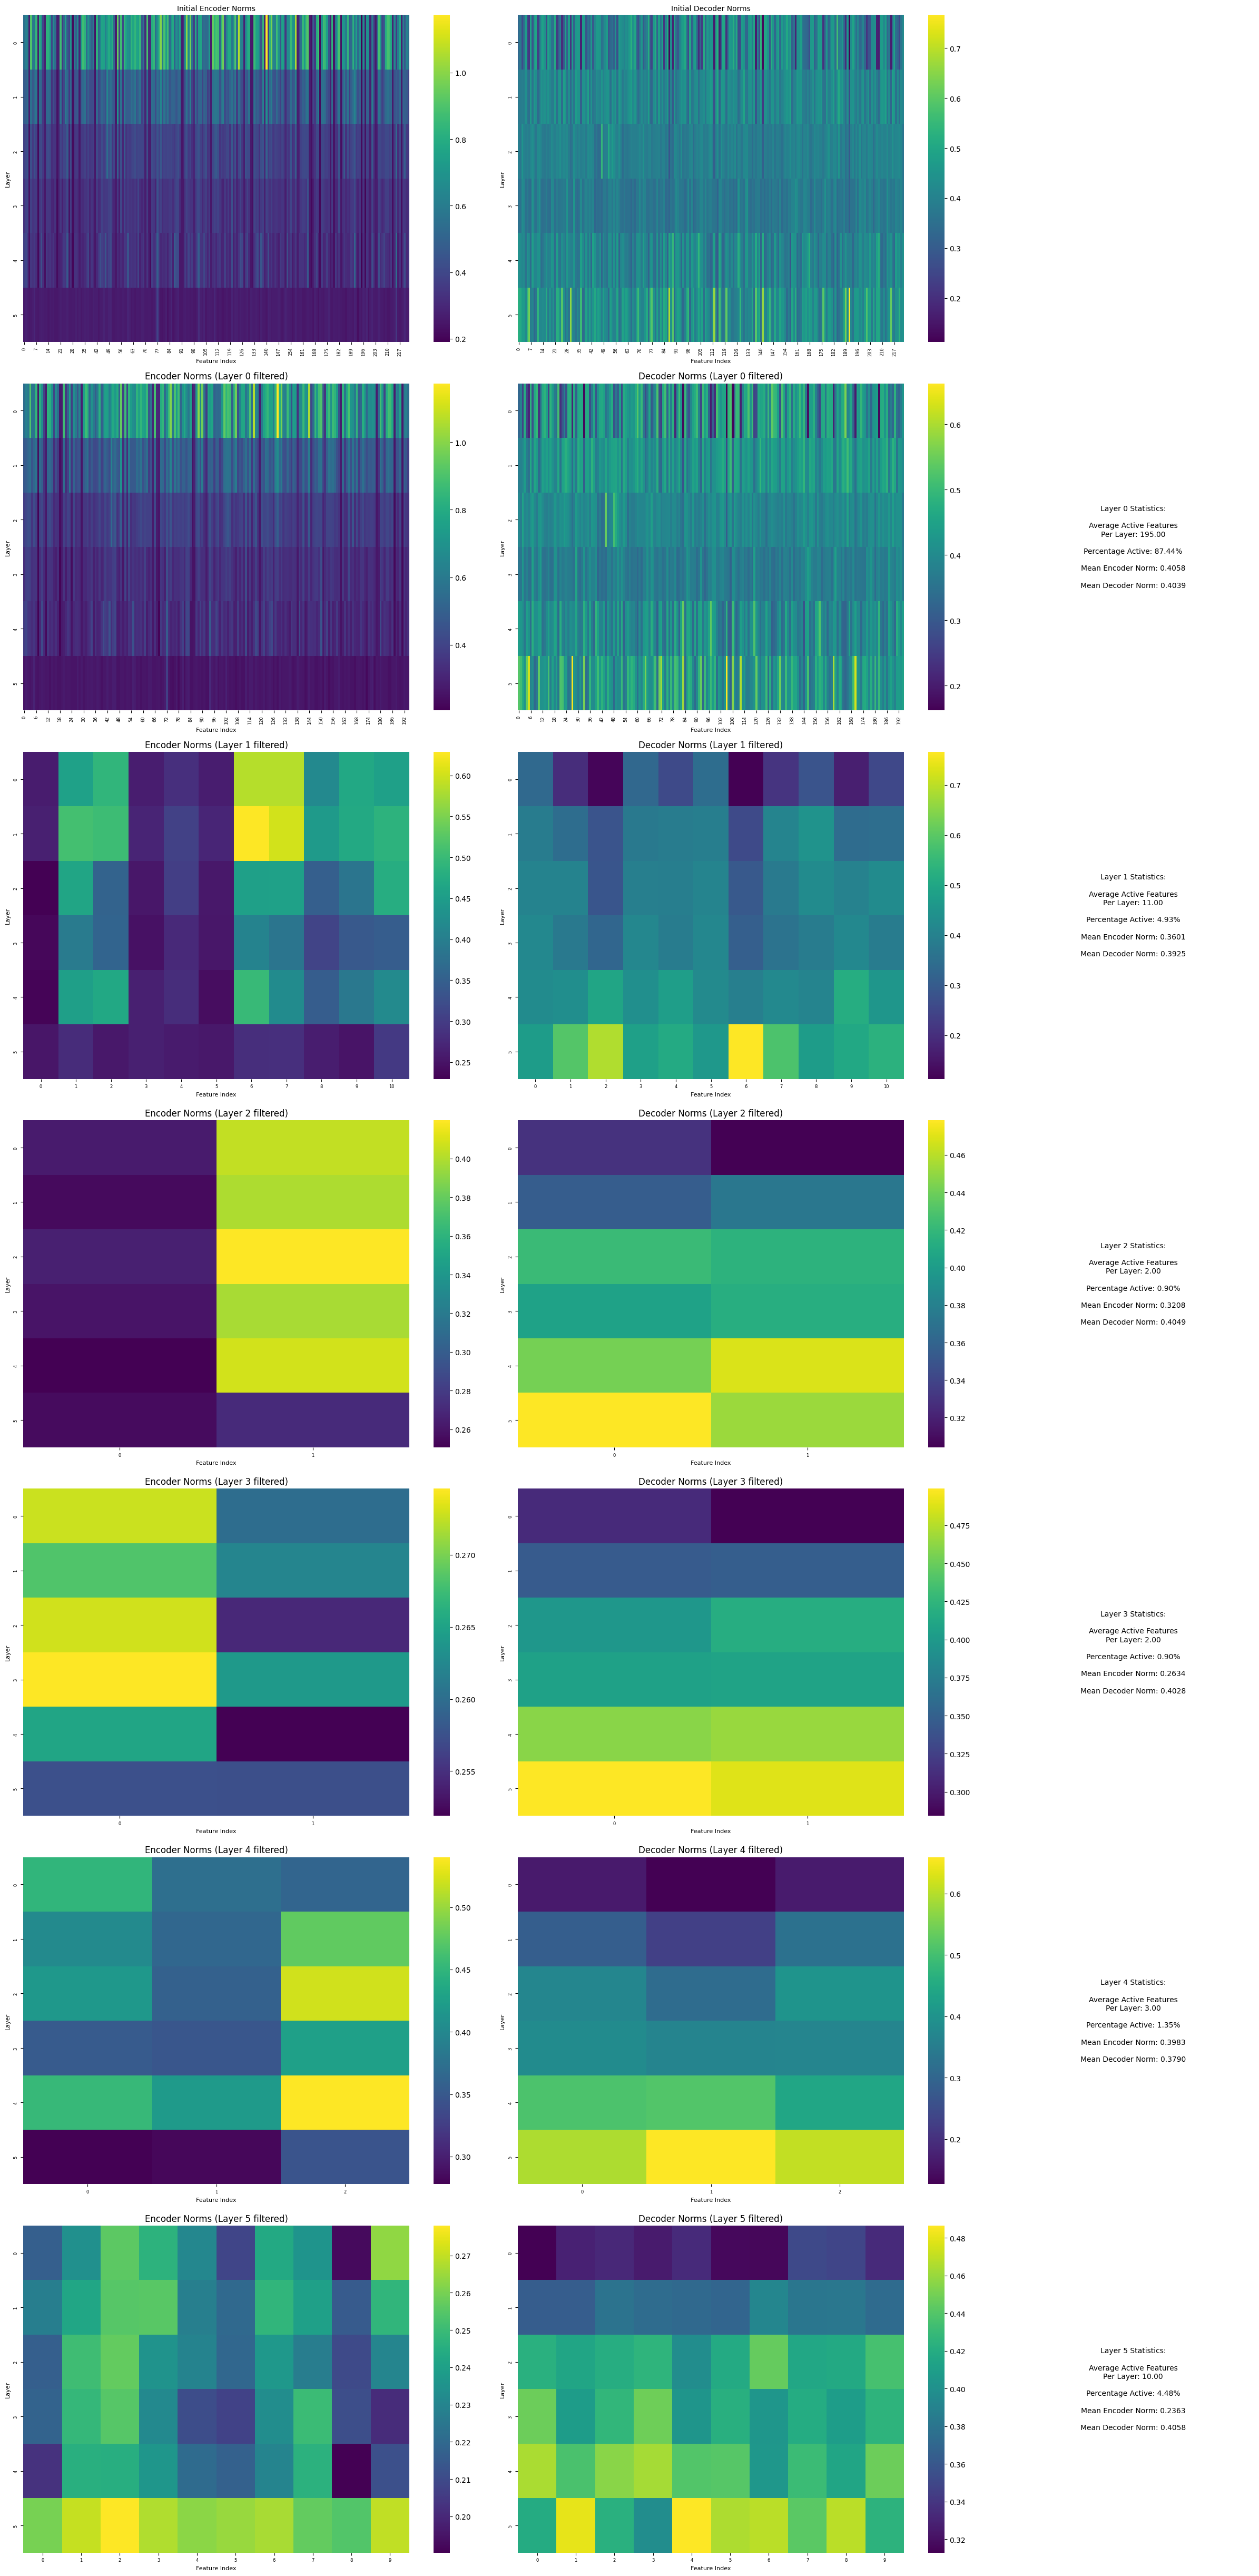

In [ ]:
# Usage example:
num_layers = 6
exclude_first_k_tokens = 0
save_folder = (
    f"../assets/{model_name}/layer_filtering_results_exclude_{exclude_first_k_tokens}"
)
activation_threshold = 0.01

filtered_encoder_weights, filtered_encoder_bias, filtered_decoder_weights = (
    filter_inactive_features(
        stats.feature_activation_rate,
        feature_encoder_weights,
        feature_encoder_bias,
        feature_decoder_weights,
        activation_threshold
    )
)


max_layer_filtering_splits, metadata = process_all_layers(
    filtered_encoder_weights,
    filtered_decoder_weights,
    filtered_encoder_bias,
    num_layers,
    exclude_first_k_tokens,
    save_folder,
)

plot_layerwise_filtering(
    filtered_encoder_weights,
    filtered_decoder_weights,
    num_layers,
    save_folder,
    norm_threshold=0.01
)